In [16]:
# Import libraries
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Set path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# Import necessary modules
from src.data.loader import ThermalDataLoader
from src.features.thermal import create_thermal_threshold_tensor
from src.features.edge_detection import create_edge_detection_tensors
from src.models.multibranch import MultiBranchModel
from src.data.dataset import ThermalDataset
from src.utils.visualization import (
    get_thermal_stats,
    print_thermal_stats,
    visualize_thermal_sequence,
    get_edge_stats,
    print_edge_stats,
    visualize_edge_sequence,
    visualize_thermal_threshold_comparison,
    get_label_examples
)

In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
def preprocess_data(data_path, is_single_file=False):
    """
    Preprocess new thermal data for prediction following the original pipeline.
    """
    # Initialize data loader
    if is_single_file:
        base_directories = [os.path.dirname(data_path)]
    else:
        base_directories = [data_path]
        
    thermal_loader = ThermalDataLoader(
        base_directories=base_directories,
        allowed_labels=None  # No labels needed for prediction
    )
    
    # Create initial dataset
    print("\nCreating dataset...")
    dataset = thermal_loader.create_dataset()
    
    if dataset is not None:
        # Follow the same preprocessing steps as in DataPreprocessing.py
        print("\nPreprocessing data...")
        
        # Convert to tensor and handle NaN values
        corrected_tensor = torch.tensor(dataset['tensors']['corrected']).float()
        if torch.isnan(corrected_tensor).any():
            print("Warning: NaN values found in corrected tensor!")
            corrected_tensor = torch.nan_to_num(corrected_tensor, nan=0.0)
        
        # Create edge detection tensors
        print("Creating edge detection tensors...")
        edge_detection_data = create_edge_detection_tensors(corrected_tensor)
        edge_tensor = torch.tensor(edge_detection_data['edge_tensor']).float()
        edge_tensor = torch.nan_to_num(edge_tensor, nan=0.0)
        
        # Create threshold tensors
        print("Creating threshold tensors...")
        threshold_data = create_thermal_threshold_tensor(corrected_tensor)
        for name, tensor in threshold_data['tensors'].items():
            threshold_data['tensors'][name] = torch.nan_to_num(tensor, nan=0.0)
        
        # Create preprocessed dataset dictionary (following original structure)
        preprocessed_dataset = {
            'tensors': {
                'corrected': corrected_tensor,
                'edge': edge_tensor,
                'threshold': threshold_data['tensors']
            },
            'metadata': dataset['metadata']
        }
        
        # Apply the same permutations as in FeatureEngineering.py
        print("\nReorganizing tensors...")
        preprocessed_dataset['tensors']['corrected'] = preprocessed_dataset['tensors']['corrected'].permute(2, 0, 1)
        preprocessed_dataset['tensors']['edge'] = preprocessed_dataset['tensors']['edge'].permute(2, 0, 1)
        
        # Handle threshold tensors permutation
        threshold_tensors = []
        for level in preprocessed_dataset['tensors']['threshold'].keys():
            permuted_tensor = preprocessed_dataset['tensors']['threshold'][level].permute(2, 0, 1)
            threshold_tensors.append(permuted_tensor)
        
        # Stack threshold tensors
        stacked_thresholds = torch.stack(threshold_tensors, dim=1)
        
        # Add channel dimension for corrected and edge tensors
        corrected = preprocessed_dataset['tensors']['corrected'].unsqueeze(1)
        edge = preprocessed_dataset['tensors']['edge'].unsqueeze(1)
        
        print("\nFinal tensor shapes:")
        print(f"Corrected: {corrected.shape}")
        print(f"Edge: {edge.shape}")
        print(f"Thresholds: {stacked_thresholds.shape}")
        
        return {
            'corrected': corrected,
            'edge': edge,
            'thresholds': stacked_thresholds,
            'metadata': dataset['metadata']
        }
    
    return None

In [6]:
def load_model_and_predict(model_path, preprocessed_data):
    """
    Load the trained model and make predictions.
    """
    print("\nLoading model and making predictions...")
    
    # Load model
    n_classes = 3
    model = MultiBranchModel(n_classes).to(device)
    
    # Load saved weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Prepare data
    with torch.no_grad():
        corrected = preprocessed_data['corrected'].float().to(device)
        edge = preprocessed_data['edge'].float().to(device)
        thresholds = preprocessed_data['thresholds'].float().to(device)
        
        # Get predictions
        outputs = model(corrected, edge, thresholds)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.cpu().numpy(), probabilities.cpu().numpy()


In [13]:
def export_predictions_to_csv(predictions, probabilities, metadata, input_dir, save_dir):
    """
    Export predictions to CSV files.
    
    Args:
        predictions: numpy array of predicted classes
        probabilities: numpy array of prediction probabilities
        metadata: dictionary containing timestamps and file information
        save_dir: directory to save CSV files
    """
        
    # Create results directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Current timestamp for file names
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    
    # Get file paths and timestamps from metadata
    file_timestamps = metadata['timestamps']  # This should be a list of timestamps from the files
    # Get list of files from input directory
    filenames = sorted([f for f in os.listdir(input_dir) if f.endswith('.fff')])
    
    # 1. Detailed predictions
    detailed_results = []
    for fname, pred, probs in zip(filenames, predictions, probabilities):
        detailed_results.append({
            'file_name': fname,
            'prediction': label_mapping[pred],
            'confidence': probs[pred] * 100,  # Convert to percentage
            'prob_despejado': probs[0] * 100,
            'prob_nublado': probs[1] * 100,
            'prob_emisiones': probs[2] * 100
        })
    
    # Save detailed results
    detailed_df = pd.DataFrame(detailed_results)
    detailed_path = os.path.join(save_dir, f'detailed_predictions_{timestamp}.csv')
    detailed_df.to_csv(detailed_path, index=False)
    
    # 2. Summary statistics
    unique_predictions, counts = np.unique(predictions, return_counts=True)
    summary_results = []
    for pred, count in zip(unique_predictions, counts):
        summary_results.append({
            'class': label_mapping[pred],
            'count': int(count),
            'percentage': float(count/len(predictions)*100)
        })
    
    # Save summary
    summary_df = pd.DataFrame(summary_results)
    summary_path = os.path.join(save_dir, f'summary_predictions_{timestamp}.csv')
    summary_df.to_csv(summary_path, index=False)
    
    print(f"\nDetailed predictions saved to: {detailed_path}")
    print(f"Summary saved to: {summary_path}")
    
    # Also print summary to console
    print("\nPrediction Summary:")
    print(summary_df.to_string(index=False))

In [7]:
# Define label mapping
label_mapping = {
    0: 'Despejado',  # Clear
    1: 'Nublado',    # Cloudy
    2: 'Emisiones'   # Emissions
}

In [15]:
if __name__ == "__main__":
    # Set paths
    model_path = os.path.join(project_root, 'data', 'processed', 'best_model.pt')
    data_path = os.path.join(project_root, 'data', 'test', 'DiarioRaw')
    save_dir = os.path.join(project_root, 'data', 'results')
    
    # Process data
    print("\nProcessing data...")
    preprocessed_data = preprocess_data(data_path, is_single_file=False)
    
    if preprocessed_data is not None:
        # Make predictions (only once)
        predictions, probabilities = load_model_and_predict(model_path, preprocessed_data)
        
        # Save torch results
        results = {
            'predictions': predictions,
            'probabilities': probabilities
        }
        results_path = os.path.join(save_dir, 'predictions.pt')
        os.makedirs(os.path.dirname(results_path), exist_ok=True)
        torch.save(results, results_path)
        print(f"\nTorch results saved to: {results_path}")
        
        # Export to CSV
        export_predictions_to_csv(
            predictions, 
            probabilities, 
            preprocessed_data['metadata'],
            data_path,  # input directory
            save_dir
        )
    else:
        print("Error: Failed to preprocess data")


Processing data...

Creating dataset...

Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\test\DiarioRaw


Processing files in DiarioRaw: 100%|██████████| 384/384 [00:04<00:00, 81.19it/s]



Successfully processed 384 files from DiarioRaw

Finalizing dataset...

Creating tensors for 384 images...
Image dimensions: 480x640
Estimated memory requirement: 0.88 GB

Allocating memory...

Processing batch 1/1

Preprocessing data...
Creating edge detection tensors...
Creating threshold tensors...

Reorganizing tensors...

Final tensor shapes:
Corrected: torch.Size([384, 1, 480, 640])
Edge: torch.Size([384, 1, 480, 640])
Thresholds: torch.Size([384, 4, 480, 640])

Loading model and making predictions...
Expected input dimensions:
Corrected & Edge branches: [batch_size, 1, 480, 640]
Threshold branch: [batch_size, 4, 480, 640]


C:\Users\Francisco\AppData\Local\Temp\ipykernel_16636\3223768146.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device


Torch results saved to: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\results\predictions.pt

Detailed predictions saved to: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\results\detailed_predictions_20250113_2238.csv
Summary saved to: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\results\summary_predictions_20250113_2238.csv

Prediction Summary:
    class  count  percentage
Despejado     58   15.104167
  Nublado    322   83.854167
Emisiones      4    1.041667


In [19]:
def visualize_predictions(preprocessed_data, predictions, probabilities, num_samples=3):
    """
    Visualize thermal images with their predictions.
    
    Args:
        preprocessed_data: Dictionary containing the preprocessed tensors and metadata
        predictions: numpy array of predicted classes
        probabilities: numpy array of prediction probabilities
        num_samples: number of samples to visualize per class (default=3)
    """
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    # Get the corrected tensor and metadata
    corrected_tensor = preprocessed_data['corrected'].squeeze(1)  # Remove channel dimension
    timestamps = preprocessed_data['metadata']['timestamps']
    
    # Calculate thermal stats
    thermal_stats = {
        'global_min': torch.min(corrected_tensor).item(),
        'global_max': torch.max(corrected_tensor).item(),
        'mean_temp': torch.mean(corrected_tensor).item(),
        'std_temp': torch.std(corrected_tensor).item()
    }
    
    # Print thermal statistics
    print("\nTemperature Statistics:")
    print(f"Global min: {thermal_stats['global_min']:.2f}°C")
    print(f"Global max: {thermal_stats['global_max']:.2f}°C")
    print(f"Mean temperature: {thermal_stats['mean_temp']:.2f}°C")
    print(f"Standard deviation: {thermal_stats['std_temp']:.2f}°C")
    
    # Get sample indices for each class
    class_indices = {}
    for class_idx in range(len(label_mapping)):
        class_samples = np.where(predictions == class_idx)[0]
        if len(class_samples) > 0:
            # Take up to num_samples samples for each class
            class_indices[class_idx] = class_samples[:num_samples]
    
    # Create visualization
    total_classes = len(class_indices)
    
    # Create figure and axes
    fig, axes = plt.subplots(total_classes, num_samples, 
                            figsize=(5 * num_samples, 5 * total_classes))
    
    # Make axes 2D even when there's only one row or column
    if total_classes == 1:
        axes = np.array([axes])
    if num_samples == 1:
        axes = axes.reshape(total_classes, 1)
    
    for row, (class_idx, indices) in enumerate(class_indices.items()):
        for col, idx in enumerate(indices):
            if col < num_samples:
                ax = axes[row, col]
                
                # Plot thermal image
                im = ax.imshow(
                    corrected_tensor[idx].cpu(),
                    cmap='inferno',
                    vmin=thermal_stats['global_min'],
                    vmax=thermal_stats['global_max']
                )
                
                # Add title with timestamp and predictions
                title = f"Time: {timestamps[idx]}\n"
                title += f"Prediction: {label_mapping[class_idx]}\n"
                title += f"Confidence: {probabilities[idx][class_idx]*100:.1f}%"
                ax.set_title(title)
                
                # Remove ticks
                ax.set_xticks([])
                ax.set_yticks([])
                
                # Add colorbar
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax=cax)
            
            # If we have fewer samples than num_samples, hide empty subplots
            if col >= len(indices):
                axes[row, col].axis('off')
    
    plt.suptitle('Thermal Images with Predictions', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return fig

C:\Users\Francisco\AppData\Local\Temp\ipykernel_16636\3323598837.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(results_path)



Creating dataset...

Processing directory: c:\Users\Francisco\Desktop\Diversa\projects\EPN\desarrollo\volcanesML\data\test\DiarioRaw


Processing files in DiarioRaw: 100%|██████████| 384/384 [00:04<00:00, 82.16it/s]



Successfully processed 384 files from DiarioRaw

Finalizing dataset...

Creating tensors for 384 images...
Image dimensions: 480x640
Estimated memory requirement: 0.88 GB

Allocating memory...

Processing batch 1/1

Preprocessing data...
Creating edge detection tensors...
Creating threshold tensors...

Reorganizing tensors...

Final tensor shapes:
Corrected: torch.Size([384, 1, 480, 640])
Edge: torch.Size([384, 1, 480, 640])
Thresholds: torch.Size([384, 4, 480, 640])

Generating visualization...

Temperature Statistics:
Global min: -7.86°C
Global max: 20.00°C
Mean temperature: 9.43°C
Standard deviation: 4.86°C


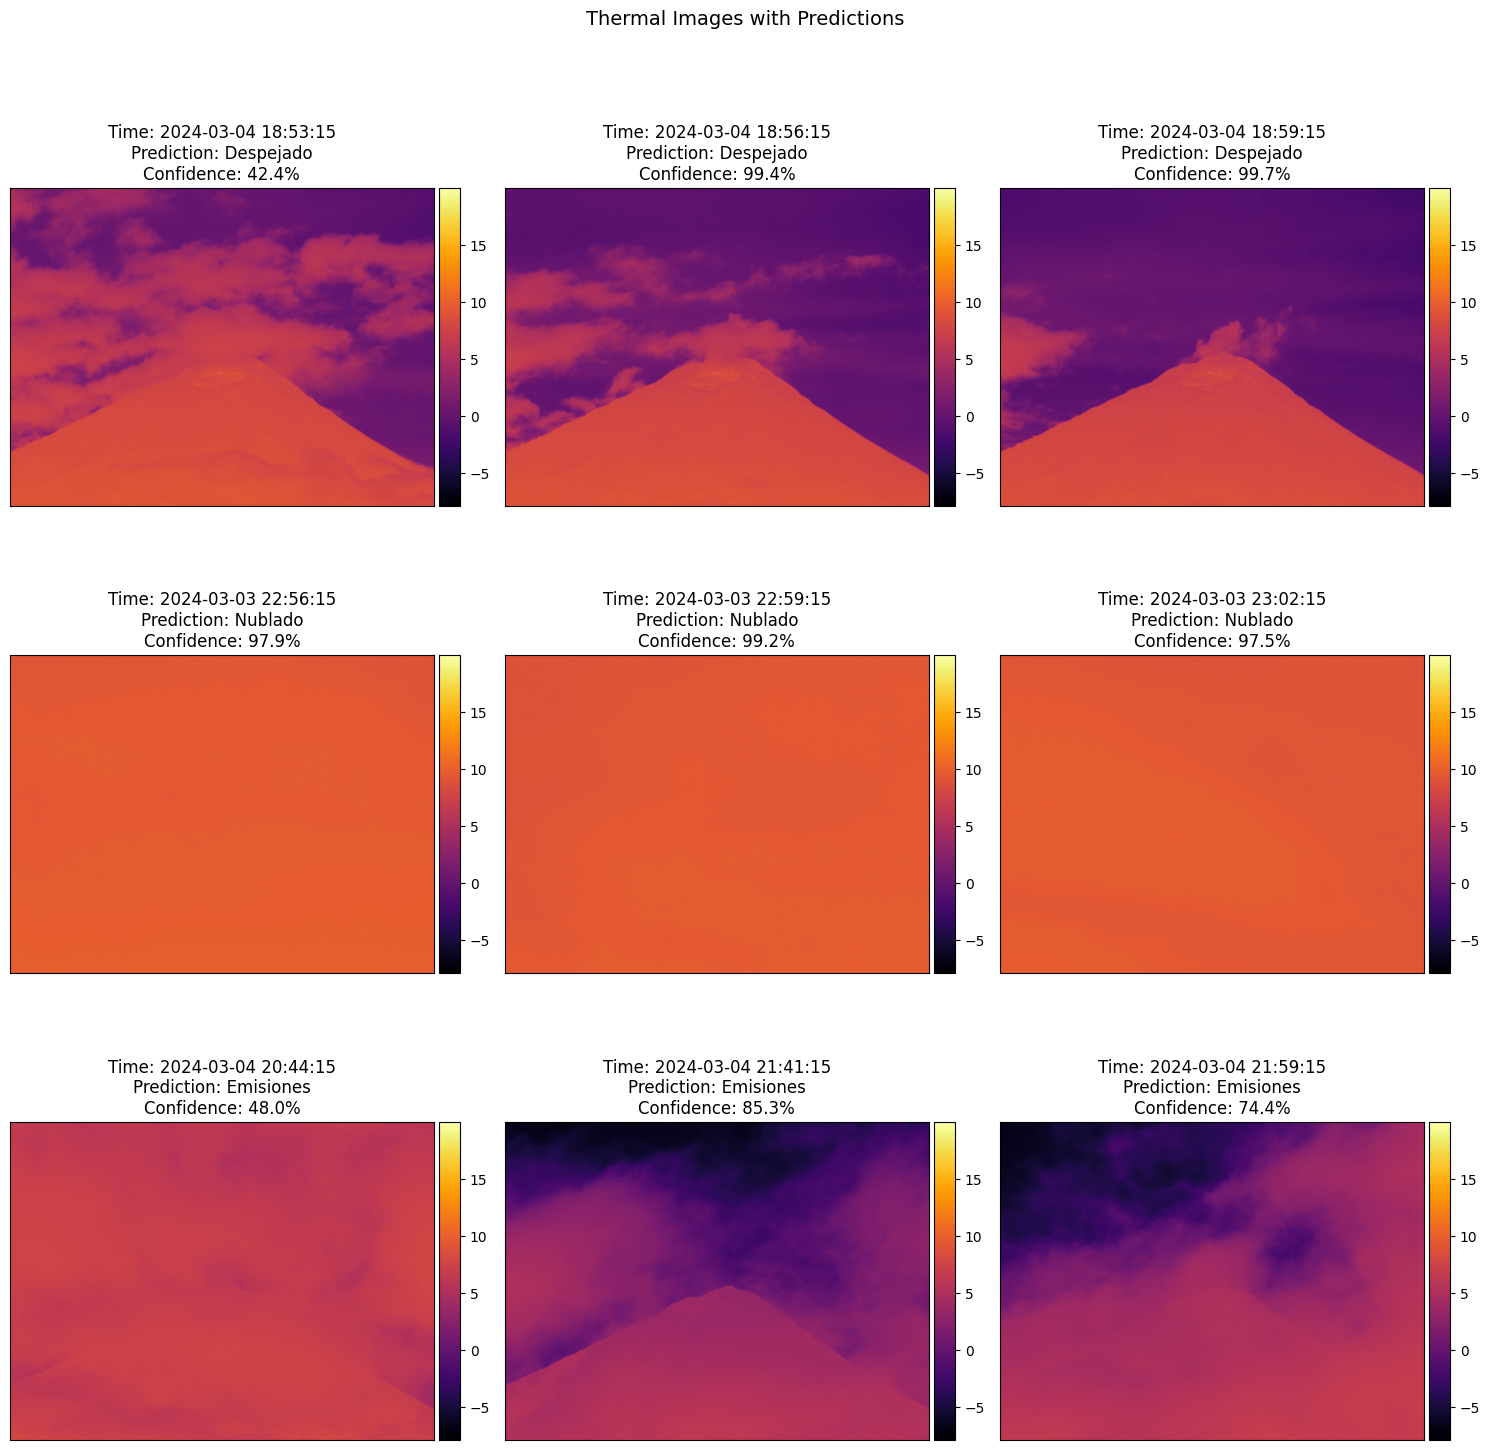

In [21]:
if __name__ == "__main__":
    # Set paths
    save_dir = os.path.join(project_root, 'data', 'results')
    results_path = os.path.join(save_dir, 'predictions.pt')
    
    # Check if preprocessed data and results exist
    if os.path.exists(results_path):
        # Load saved results
        results = torch.load(results_path)
        predictions = results['predictions']
        probabilities = results['probabilities']
        
        # Load and preprocess data again (needed for visualization)
        data_path = os.path.join(project_root, 'data', 'test', 'DiarioRaw')
        preprocessed_data = preprocess_data(data_path, is_single_file=False)
        
        if preprocessed_data is not None:
            # Generate visualization with 3 samples per class
            print("\nGenerating visualization...")
            fig = visualize_predictions(preprocessed_data, predictions, probabilities, num_samples=3)
            
            # Optionally save the figure
            fig.savefig(os.path.join(save_dir, 'thermal_predictions.png'), bbox_inches='tight', dpi=300)
        else:
            print("Error: Failed to load data for visualization")
    else:
        print(f"Error: No prediction results found at {results_path}")